In [71]:
from nltk.tokenize import RegexpTokenizer
import re
from collections import defaultdict, Counter # for the model
from nltk.util import ngrams 
import pandas as pd # dataframes 
import numpy as np 
import random
import matplotlib.pyplot as plt
import glob # read multiple files
import nltk
from operator import itemgetter

# Text Prediction with Conditional Probabilities

In [72]:
# data can be found here https://github.com/bing020815/text_prediction_application/tree/master/data/aclImdb
train_pos_filenames = glob.glob('/Users/jasonmaloney/Documents/Syracuse/IST 736 Text Mining/Text Mining Project/aclImdb/train/pos/*.txt')
train_neg_filenames = glob.glob('/Users/jasonmaloney/Documents/Syracuse/IST 736 Text Mining/Text Mining Project/aclImdb/train/neg/*.txt')
test_pos_filenames = glob.glob('/Users/jasonmaloney/Documents/Syracuse/IST 736 Text Mining/Text Mining Project/aclImdb/test/pos/*.txt')
test_neg_filenames = glob.glob('/Users/jasonmaloney/Documents/Syracuse/IST 736 Text Mining/Text Mining Project/aclImdb/test/neg/*.txt')
print(len(train_pos_filenames))
print(len(train_neg_filenames))
print(len(test_pos_filenames))
print(len(test_neg_filenames))

12500
12500
12500
12500


In [73]:
%time
# read the contents of the train_pos files into a list (each list element is one review)
# clean line breaks and html tags like <br\>
train_pos_text = []
for filename in train_pos_filenames:
    with open(filename, encoding='utf-8') as f:
        text = f.read()
        text = text.lower()
        text = re.sub(r'\n|<\w+\s/>', '', text)
        train_pos_text.append(text)
print("train_pos_text:")
print(train_pos_text[0])


# read the contents of the train_pos files into a list (each list element is one review)
train_neg_text = []
for filename in train_neg_filenames:
    with open(filename, encoding = 'utf-8') as f:
        text = f.read()
        text = text.lower()
        text = re.sub(r'\n|<\w+\s/>', '', text)
        train_neg_text.append(text)
print("\ntrain_neg_text:")
print(train_neg_text[0])

test_pos_text = []
for filename in test_pos_filenames:
    with open(filename, encoding = 'utf-8') as f:
        text = f.read()
        text = text.lower()
        text = re.sub(r'\n|<\w+\s/>', '', text)
        test_pos_text.append(text)
print('\ntest_pos_text:')
print(test_pos_text[0])

test_neg_text = []
for filename in test_neg_filenames:
    with open(filename, encoding = 'utf-8') as f:
        text = f.read()
        text = text.lower()
        text = re.sub(r'\n|<\w+\s/>', '', text)
        test_neg_text.append(text)
print('\ntest_neg_text:')
print(test_neg_text[0])

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.9 µs
train_pos_text:
for a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. imagine a movie where joe piscopo is actually funny! maureen stapleton is a scene stealer. the moroni character is an absolute scream. watch for alan "the skipper" hale jr. as a police sgt.

train_neg_text:
working with one of the best shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.branagh steals the film from under fishburne's nose, and there's a talented cast on good form.

test_pos_text:
based on an actual story, john boorman shows the struggle of an american doctor, whose husband and son were murdered and she was continually plagued with her loss. a holiday to burma with her sister seemed like a good idea to get away from it all, but when her passport was stolen in rangoon, she could not leave the country with her sister, and was forced to

In [74]:
# combine all reviews into a long string to get more n-grams
words = ''
for rev in train_pos_text:
    words += ' ' + rev

for rev in train_neg_text:
    words += ' ' + rev
    
for rev in test_pos_text:
    words += ' ' + rev

for rev in test_neg_text:
    words += ' ' + rev

# define tokenizer to get words
tokenizer = RegexpTokenizer(r'\w+')

# words has all the review as one string
tokens = tokenizer.tokenize(words)
print('There are {} tokens. '.format(len(tokens)))
print('There are {} unique tokens. '.format(len(set(tokens))))

There are 11772360 tokens. 
There are 104138 unique tokens. 


In [75]:
# define the default dictionary - used for saving the model with dill library
def default_dict():
    return defaultdict(int)

In [76]:
# get frequency distributions
fdist = nltk.FreqDist(tokens)
tag_tokens = nltk.pos_tag(tokens)
tag_fd = nltk.FreqDist(tag for (word, tag) in tag_tokens)

# Bigram Part Of Speech Model

In [77]:
# function to get the conditional probability of word2 given word1
# P(pos2|pos1)
def build_tag_bigram_model():
    tag_bigram_model = defaultdict(default_dict) # create a model mold
    # collect all bigrams and the POS for each word
    # tag_tokens has tuples of (word, POS)
    for tuple1, tuple2 in ngrams(tag_tokens, 2):
        # increase the count (frequency of tokens)
        tag_bigram_model[tuple1[1]][tuple2[1]] += 1
    # compute the probability P(word2|word1)
    for pos1 in tag_bigram_model:
        # get total count of bigrams with word1
        total_count = float(sum(tag_bigram_model[pos1].values()))
        for pos2 in tag_bigram_model[pos1]:
            # number of bigrams (word1 word2)/total
            tag_bigram_model[pos1][pos2] /= total_count
    return tag_bigram_model

In [78]:
tag_bigram_model = build_tag_bigram_model()

In [79]:
# function to predict the next word based on bigram model
def bigram_predict_next_pos(first_pos):
    if len(tag_bigram_model[first_pos]) == 0:
        return None
    else:
        # get probabilities of next POS given user input
        prob_list = tag_bigram_model[first_pos].values()
        #print(prob_list)
        # find the max prob
        most_likely = max(prob_list)
        #print(most_likely)
        # predicted words
        pred_pos = [pos for pos, prob in tag_bigram_model[first_pos].items() if prob == most_likely]
    return pred_pos

In [80]:
bigram_predict_next_pos('VBD')

['DT']

# Trigram Part Of Speech Model

In [81]:
# function to get the conditional probability of word2 given word1
# P(pos3|pos1, pos2)
def build_tag_trigram_model():
    tag_trigram_model = defaultdict(default_dict) # create a model mold
    # collect all bigrams and the POS for each word
    # tag_tokens has tuples of (word, POS)
    for tuple1, tuple2, tuple3 in ngrams(tag_tokens, 3):
        # increase the count (frequency of tokens)
        tag_trigram_model[tuple1[1], tuple2[1]][tuple3[1]] += 1
    # compute the probability P(word2|word1)
    for pos1, pos2 in tag_trigram_model:
        # get total count of bigrams with word1
        total_count = float(sum(tag_trigram_model[pos1, pos2].values()))
        for pos3 in tag_trigram_model[pos1, pos2]:
            # number of bigrams (word1 word2)/total
            tag_trigram_model[pos1, pos2][pos3] /= total_count
    return tag_trigram_model

In [82]:
tag_trigram_model = build_tag_trigram_model()

In [83]:
# function to predict the next word based on bigram model
def trigram_predict_next_pos(first_pos, second_pos):
    if len(tag_trigram_model[first_pos, second_pos]) == 0:
        return None
    else:
        # get probabilities of next POS given user input
        prob_list = tag_trigram_model[first_pos, second_pos].values()
        #print(prob_list)
        # find the max prob
        most_likely = max(prob_list)
        #print(most_likely)
        # predicted words
        pred_pos = [pos for pos, prob in tag_trigram_model[first_pos, second_pos].items() if prob == most_likely]
    return pred_pos

In [84]:
trigram_predict_next_pos('VBD', 'DT')

['NN']

In [85]:
tag_trigram_model['DT', 'NN']

defaultdict(int,
            {'WDT': 0.019734499771120493,
             'EX': 0.002996626146516793,
             'IN': 0.2730998762355255,
             'VB': 0.00405766633323726,
             'WRB': 0.011503314514351593,
             'NN': 0.16217102102865796,
             'CC': 0.07341522133496092,
             'TO': 0.027358165347077405,
             'VBZ': 0.11575227890522127,
             'VBN': 0.009717489220057756,
             'PRP': 0.03904232292920559,
             'VBG': 0.017295944029070524,
             'RB': 0.050774516951211934,
             'DT': 0.04533085804384314,
             'NNS': 0.020876071636460224,
             'VBD': 0.050510316531882066,
             'JJ': 0.024415226986306788,
             'MD': 0.014416583309315114,
             'WP': 0.011234875585620715,
             'VBP': 0.008768063114230654,
             'CD': 0.005940977343754415,
             'RP': 0.0022308687814002904,
             'PRP$': 0.0034261284324861967,
             'RBR': 0.0016247619370

## Most Common Word in all POS tags

In [86]:
# list of all the POS in the corpus
pos_tag_list = []
for pos, count in tag_fd.most_common():
    pos_tag_list.append(pos)
#print(pos_tag_list)

In [87]:
# get counts of words with POS tags
word_tag_fd = nltk.FreqDist(tag_tokens)
#word_tag_fd.most_common(10)
# word_tag_fd is a tuple ((word, POS), count)

In [88]:
# get the top word of each part of speech tag
# empty dictionary
pos_word_dict = {}
# iterate through each part of speech
for pos in pos_tag_list:
    # keep only the most common word for each POS tag - create a list and keep the first element
    # first element is most common because .most_common() is sorted by count
    # word_tag_fd is a tuple ((word, POS), count)
    # word = word_tag[0], pos = word_tag[1]
    pos_word_dict[pos] = [word_tag[0] for (word_tag, count) in word_tag_fd.most_common() if word_tag[1] == pos][0]
    #print([wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == pos][0], '---', pos)
pos_word_dict

{'NN': 'i',
 'DT': 'the',
 'IN': 'of',
 'JJ': 'i',
 'RB': 'not',
 'NNS': 'people',
 'VBZ': 'is',
 'PRP': 'it',
 'CC': 'and',
 'VB': 'be',
 'VBP': 'are',
 'VBD': 'was',
 'TO': 'to',
 'VBN': 'been',
 'VBG': 'being',
 'PRP$': 'his',
 'CD': 'one',
 'MD': 'can',
 'WP': 'who',
 'WRB': 'when',
 'WDT': 'that',
 'RP': 'up',
 'JJS': 'best',
 'JJR': 'more',
 'EX': 'there',
 'RBR': 'more',
 'PDT': 'all',
 'RBS': 'most',
 'FW': 'etc',
 'NNP': 'x',
 'WP$': 'whose',
 'UH': 'oh',
 '$': 'zombi',
 'NNPS': 'republicans',
 "''": 'marry',
 'SYM': 'b',
 'POS': 's',
 '``': 'neighbour'}

# Bigram Text Prediction

In [89]:
# function to get the conditional probability of word2 given word1
# P(word2|word1)
def build_bigram_model():
    bigram_model = defaultdict(default_dict) # create a model mold
    # collect all bigrams for (w1, w2)
    for word1, word2 in ngrams(tokens, 2):
        # increase the count (frequency of tokens)
        bigram_model[word1][word2] += 1
    # compute the probability P(word2|word1)
    for word1 in bigram_model:
        # get total count of bigrams with word1
        total_count = float(sum(bigram_model[word1].values()))
        for word2 in bigram_model[word1]:
            # number of bigrams (word1 word2)/total
            bigram_model[word1][word2] /= total_count
    return bigram_model

In [90]:
# build the model
bigram_model = build_bigram_model()

In [91]:
# function to predict the next word based on bigram model
# input is a list of tokens
def bigram_predict_next_word(token):
    if len(bigram_model[token]) == 0:
        # get POS of the input word
        #token = tokenizer.tokenize(first_word)
        # get the part of speech [(word, POS)]
        pos = nltk.pos_tag(token)[0][1]
        # predict next word POS - returns a list
        pred_pos = bigram_predict_next_pos(pos)
        # get the most common word of predicted POS
        pred_words = pos_word_dict[pred_pos[0]]
    
    else:
        # tokenize user input
        #user_tokens = tokenizer.tokenize(first_word)
        #print('input:', user_tokens[0])
        # get probabilities of next word given user input
        prob_list = bigram_model[token].values()
        #print(prob_list)
        # find the max prob
        most_likely = max(prob_list)
        #print(most_likely)
        # predicted words
        pred_words = [word for word, prob in bigram_model[token].items() if prob == most_likely]
        # if there is more than one predicted word, return the most frequent in the corpus
        if len(pred_words) > 1:
            word_dict = {}
            # get the frequency counts of the predicted word
            for word in pred_words:
                word_dict[word] = fdist[word]
            # get the word with max freqency
            for word,count in word_dict.items():
                if count == max(word_dict.values()):
                    pred_words = word
            
    return pred_words
    

In [92]:
user_input = tokenizer.tokenize('but') # <- input a word here
# stores as a list - use the first entry as the word
bigram_predict_next_word(user_input[0])

['it']

# Trigram Text Prediction

In [93]:
def build_trigram_model():
    trigram_model = defaultdict(default_dict) # create a model mold
    # collect trigrams for word1, word2, word3
    for word1, word2, word3 in ngrams(tokens , 3):
        # increase the count 
        trigram_model[word1, word2][word3] += 1
        # compute the probability P(word1, word|word3)
    for word1_word2 in trigram_model:
        # get total count of trigrams with word1 word2
        total_count = float(sum(trigram_model[word1_word2].values()))
        for word3 in trigram_model[word1_word2]:
            # number of trigrams/total
            trigram_model[word1_word2][word3] /= total_count
    return trigram_model   

In [94]:
# define the model
trigram_model = build_trigram_model()

In [95]:
# function to predict next word with trigram model
def trigram_predict_next_word(tokens):
    # tokenize user input
    #user_tokens = tokenizer.tokenize(two_words)
    #print(user_tokens)
    # if input is not in the vocabulary - use POS
    if len(trigram_model[tokens[-2], tokens[-1]]) == 0:
        # get POS of the input words
        tagged_words = nltk.pos_tag(tokens[-2], tokens[-1])
        pos1, pos2 = tagged_words[0][1], tagged_words[1][1]
        # predict next word POS - needs two arguments
        pred_pos = trigram_predict_next_pos(pos1, pos2)
        #print(pred_pos)
        # get the most common word of predicted POS
        pred_words = pos_word_dict[pred_pos[0]]
        
    else:
        # get probabilities of next word
        prob_list = trigram_model[tokens[-2], tokens[-1]].values()
        # find the max prob
        #print(prob_list)
        most_likely = max(prob_list)
        #print(most_likely)
        # predicted words
        pred_words = [word for word, prob in trigram_model[tokens[-2], tokens[-1]].items() if prob == most_likely]
        # if there are more than one word in pred_words
        if len(pred_words) > 1:
            # create a dictionary to pair up words and counts
            word_dict = {}
            # iterate through all pred_words choices
            for word in pred_words:
                # add word:count to dictionary
                word_dict[word] = fdist[word]
            for word,count in word_dict.items():
                # find the word that has the highest count - that is the word to return
                if count == max(word_dict.values()):
                    pred_words = word
    return pred_words

In [96]:
user_input = tokenizer.tokenize('the oven') # <- input a phrase here
trigram_predict_next_word(user_input)

'to'

In [97]:
trigram_model['the', 'movie']

defaultdict(int,
            {'is': 0.128909197618848,
             'with': 0.007713591011989603,
             'very': 0.001509180850171879,
             'was': 0.05906766160811604,
             'spooky': 4.1921690282552195e-05,
             'has': 0.01852938710488807,
             'had': 0.008635868198205752,
             'looks': 0.001970319443279953,
             'parolini': 4.1921690282552195e-05,
             'ending': 8.384338056510439e-05,
             'shows': 0.002179927894692714,
             'itself': 0.010438500880355497,
             'will': 0.002808753248930997,
             'features': 0.0009222771862161483,
             'i': 0.03345350884547665,
             'progresses': 0.001760710991867192,
             'though': 0.0015930242307369833,
             'so': 0.005449819736731785,
             'like': 0.0016349459210195354,
             'not': 0.0027249098683658924,
             'wait': 0.00016768676113020878,
             'ends': 0.004317934099102876,
             'and':

# Interactive User Input
Enter in any number of words
- 1 word, use bigram model
- at least 2 words, use the last two words in trigram model

In [98]:
def make_prediction(text):
    '''
        input: string of text
    function: tokenize the string
        1. if string has 2 or more tokens, use the last two tokens
        with trigram prediction
        2. if string has 1 token, use bigram prediction
    return: predicted word
    '''
    user_tokens = tokenizer.tokenize(text)
    #print(user_tokens)
    if len(user_tokens) >= 2:
        pred_words = trigram_predict_next_word(user_tokens)[0]
    elif len(user_tokens) == 1:
        user_tokens = user_tokens[0]
        pred_words = bigram_predict_next_word(user_tokens)[0]
    return print('The predicted next word:', pred_words)
    

# Directions
1. Press shift + enter
2. Type a phrase
3. Press enter


In [106]:
user_input = input('Please enter a phrase: ')
print(user_input)
make_prediction(user_input)

Please enter a phrase: an engine
an engine
The predicted next word: a


In [100]:
# code to create the slides
# run this in the terminal
# change the directory first
#jupyter nbconvert Yard Prediction Field Graph.ipynb --to slides --post serve

# Bar Graphs for Reports

In [101]:
# from Bing-Je
def trigram_predict_next_word_chart(words):
    user_tokens = tokenizer.tokenize(words)
    # get the next word
    next_word = trigram_model[(user_tokens[0], user_tokens[1])]
    pred_words = trigram_predict_next_word(words)
    # get the top 10 words for next word
    top10words = Counter(next_word).most_common(10)
    
    if len(top10words) > 0:
        predicted_words = list(zip(*top10words))[0]
        prob_score = list(zip(*top10words))[1]
        x_pos = np.arange(len(predicted_words))
        
        plt.bar(x_pos, prob_score, align = 'center')
        for i in range(len(x_pos)):
            plt.text(x = i - 0.35, y = prob_score[i] + 0.005,
                    s = round(prob_score[i], 3))
        plt.xticks(x_pos, predicted_words)
        plt.ylabel('Probability Score')
        plt.xlabel('Predicted Words')
        plt.title('Predicted words for "{} {}" with Trigram model'.format(user_tokens[0], user_tokens[1]))
        plt.ylim(0, max(prob_score)+0.02)
        plt.show()
        
        if len(pred_words) > 1:
            y = []
            for word in pred_words:
                y.append(fdist[word])
            plt.bar(x_pos, y)
            for i in range(len(predicted_words)):
                plt.text(x = i - 0.25, y = y[i], s = y[i])
            plt.xticks(x_pos, pred_words)
            plt.ylabel('Overall Count')
            plt.xlabel('Predicted Words')
            plt.title('Word to choose from predicted word list')
            plt.show()
    else:
        print('no luck')

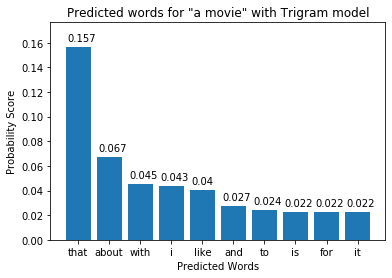

In [102]:
trigram_predict_next_word_chart('a movie')

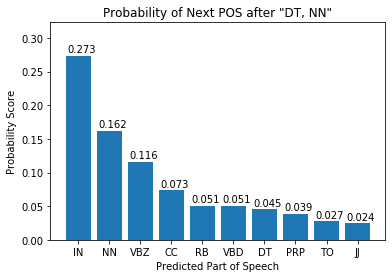

In [103]:
dt_tups = tag_trigram_model['DT', 'NN']
lists = sorted(dt_tups.items(), key=lambda dt_tups: dt_tups[1], reverse = True) # sorted by key, return a list of tuples

x, y = zip(*lists[:10]) # unpack a list of pairs into two tuples
for i in np.arange(0,10):
    plt.text(x = i - 0.35, y = y[i] + 0.005,
            s = str(round(y[i], 3)))
#plt.text(x = np.arange(0,10)-0.3, y = y + 0.01, s = str(round(y,3)))
plt.bar(x, y)
plt.title('Probability of Next POS after "DT, NN"')
plt.xlabel('Predicted Part of Speech')
plt.ylabel('Probability Score')
plt.ylim(0, max(y)+0.05)
plt.show()

In [104]:
y[1]

0.16217102102865796